# Regression and Classification in one Model

Goal is to use one model for a regression and a classification. For that I go with the articles from watson.ch again. I want to predict the author of the article (classification) and the number of comments (regression) based on the article. 

## Data

In [1]:
import pandas as pd
#import Python libaries needed for training embbeded vectors 
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec
import time # for checking how long the training process takes
import re
import string
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import ipynb.fs.full.Classifier as cl#from https://github.com/ptnplanet/NLTK-Contributions/blob/master/ClassifierBasedGermanTagger/ClassifierBasedGermanTagger.py
import random
% matplotlib inline

In [2]:
# load the dataset
articles = pd.read_csv("C:\\Users\\gwehrm\\Documents\\Repos\\watson_analysis\\watson_schweiz.csv",sep = ";")
articles.head(5)

,title,author,date,nmbr_comments,themes,article
0,Tourismus-Professor pendelt mit Flugzeug zur A...,no_author,"28.03.19, 22:15 28.03.19, 22:40",19,"['Schweiz', 'Gesellschaft & Politik', 'Klima']","['Naaa, wie kommt ihr so zur Uni? Mit dem Fahr..."
1,no_title,no_author,no_date,no_comments,[],['\r\n\t\tMit deiner Anmeldung erklärst du dic...
2,Anstatt mit Bus und Zug fahren mehr Menschen m...,no_author,"28.03.19, 17:39",29,"['Schweiz', 'Gesellschaft & Politik', 'Mobilit...",['\nDer Ausbau des öffentlichen Verkehrs würde...
3,Über 80'000 Franken bei Online-Bank N26 geklau...,no_author,"28.03.19, 17:34",18,"['Digital', 'Schweiz', 'Datenschutz', 'Deutsch...",['\nDie gefeierte Online-Bank N26 verspielt ge...
4,Der Wolf ist zurück – was auch Städter wissen ...,no_author,"28.03.19, 16:19",45,"['Schweiz', 'Wissen', 'Aargau', 'Natur', 'Tier']",['\nDer gesetzliche Schutz des Wolfes wird der...


In [3]:
# filter no_author
data_reduced = articles[-articles['author'].str.contains("no_author")]
# authors_article = data_reduced.groupby('author').count().reset_index()
# for simplicity I will reduce the number of authors. I set a threshold of minimum 50 articles 


# Importing necessary libraries
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
data_reduced["author"] = labelencoder.fit_transform(data_reduced["author"])


g = data_reduced.groupby('author')
data_reduced = g.filter(lambda x: len(x) > 50).reset_index(drop = True)
display(data_reduced.groupby('author').count())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,title,date,nmbr_comments,themes,article
author,,,,,
1,63,63,63,63,63
5,113,113,113,113,113
7,149,149,149,149,149
15,104,104,104,104,104
16,152,152,152,152,152
19,155,155,155,155,155
28,52,52,52,52,52
42,133,133,133,133,133
49,99,99,99,99,99


In [4]:
data_reduced.head()

,title,author,date,nmbr_comments,themes,article
0,Zielscheibe der Wut – Tamara Funiciello auf de...,49,"28.03.19, 11:28 28.03.19, 12:40",392,"['Schweiz', 'Facebook', 'Feminismus', 'Gesells...",['\nTamara Funiciello: Juso-Präsidentin und Zi...
1,Der Hass im Netz nimmt zu – was bedeutet das f...,57,"27.03.19, 10:29 27.03.19, 18:58",26,"['Schweiz', 'Best of watson', 'Facebook', 'Ges...",['Die aktuelle Kriminalstatistik zeigt deutlic...
2,Der Kampf um den Waschturm – ein Zürcher Krie...,57,"26.03.19, 09:26 27.03.19, 01:36",70,"['Schweiz', 'Best of watson', 'Gesellschaft & ...",['Tatort: Ein Mehrfamilienhaus in Zürich Wipki...
3,«Das ist erst der Anfang»: So reagiert die Kli...,1,"25.03.19, 18:42 26.03.19, 11:01",41,"['Schweiz', 'Best of watson', 'Klima', 'Klimas...",['Die Klimastreik-Bewegung feiert mit dem Erdr...
4,Warum das Klima rockt und Europa nicht: 5 Erke...,42,"25.03.19, 14:53 26.03.19, 06:49",33,"['Schweiz', 'BDP', 'Best of watson', 'CVP', 'F...",['\nDie Parteipräsidenten Konrad Langhart (SVP...


In [5]:
# it looks quite alright. only problem is that we have the \n in front. with string replace to solve
data_reduced["article"] = [art.replace("\\n","").replace("\n","").replace("\r","").replace("\t","") for art in data_reduced["article"]]

In [6]:
# remove punctuation
exclude = set(string.punctuation)
for index,s in enumerate(data_reduced["article"]):
    exclude = set(string.punctuation)
    data_reduced.loc[index,"article"]= ''.join(ch for ch in s if ch not in exclude)

In [7]:
display(data_reduced.head())
display(data_reduced.shape)
# the articles look alright now
# and in total 1080 articles

,title,author,date,nmbr_comments,themes,article
0,Zielscheibe der Wut – Tamara Funiciello auf de...,49,"28.03.19, 11:28 28.03.19, 12:40",392,"['Schweiz', 'Facebook', 'Feminismus', 'Gesells...",Tamara Funiciello JusoPräsidentin und Zielsche...
1,Der Hass im Netz nimmt zu – was bedeutet das f...,57,"27.03.19, 10:29 27.03.19, 18:58",26,"['Schweiz', 'Best of watson', 'Facebook', 'Ges...",Die aktuelle Kriminalstatistik zeigt deutlich ...
2,Der Kampf um den Waschturm – ein Zürcher Krie...,57,"26.03.19, 09:26 27.03.19, 01:36",70,"['Schweiz', 'Best of watson', 'Gesellschaft & ...",Tatort Ein Mehrfamilienhaus in Zürich Wipkinge...
3,«Das ist erst der Anfang»: So reagiert die Kli...,1,"25.03.19, 18:42 26.03.19, 11:01",41,"['Schweiz', 'Best of watson', 'Klima', 'Klimas...",Die KlimastreikBewegung feiert mit dem Erdruts...
4,Warum das Klima rockt und Europa nicht: 5 Erke...,42,"25.03.19, 14:53 26.03.19, 06:49",33,"['Schweiz', 'BDP', 'Best of watson', 'CVP', 'F...",Die Parteipräsidenten Konrad Langhart SVP link...


(1080, 6)

In [8]:
#dowloading the stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gwehrm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
from nltk.corpus import stopwords

In [10]:
# read in the dowloaded corpus to train the tagger
corp = nltk.corpus.ConllCorpusReader('C:\\Users\\gwehrm\\Documents', 'tiger_release_aug07.corrected.16012013.conll09',
                                     ['ignore', 'words', 'ignore', 'ignore', 'pos'],
                                     encoding='utf-8')

tagged_sents = list(corp.tagged_sents())
random.shuffle(tagged_sents)

# set a split size: use 90% for training, 10% for testing
split_perc = 0.1
split_size = int(len(tagged_sents) * split_perc)
train_sents, test_sents = tagged_sents[split_size:], tagged_sents[:split_size]

# from ClassifierBasedGermanTagger
#train the classifier ()
tagger = cl.ClassifierBasedGermanTagger(train=train_sents)

from germalemma import GermaLemma
lemmatizer = GermaLemma()

accuracy = tagger.evaluate(test_sents)

In [11]:
#the accuracy of the trained tagger (it was trained on the tiger corpus)
display(accuracy)

0.9409471066907775

In [12]:
# in a list comprehension, first tag the word correctly and remove if it is a german stopword
for index,article in enumerate(data_reduced["article"]):
    data_reduced["article"][index]= tagger.tag([word for word in article.split() if word.lower() not in stopwords.words('german')])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
display(data_reduced["article"].head())
# the data is now tagged.

0    [(Tamara, NE), (Funiciello, NE), (JusoPräsiden...
1    [(aktuelle, ADJA), (Kriminalstatistik, NN), (z...
2    [(Tatort, NN), (Mehrfamilienhaus, NE), (Zürich...
3    [(KlimastreikBewegung, NE), (feiert, VVFIN), (...
4    [(Parteipräsidenten, NE), (Konrad, NE), (Langh...
Name: article, dtype: object

In [14]:
# to get the stem of the word, lemmatization needs to be done for each word

from germalemma import GermaLemma
lemmatizer = GermaLemma()
# passing the word and the POS tag 
for index, tos in enumerate(data_reduced["article"]):
    article_w=[]
    for i in tos:
        try:
            word, N = i
            lemma = lemmatizer.find_lemma(word,N)
            article_w.append(lemma)
        except ValueError:
            continue
    data_reduced.at[index,"article"] = article_w


In [15]:
data_reduced["article"].head()
# the artiles look fine now. they are 

0    [Tamara, Funiciello, JusoPräsidentin, Zielsche...
1    [aktuell, Kriminalstatistik, zeigen, deutlich,...
2    [Tatort, Mehrfamilienhaus, Zürich, Wipkingen, ...
3    [KlimastreikBewegung, feiern, ÖkoParteien, ers...
4    [Parteipräsidenten, Konrad, Langhart, SVP, lin...
Name: article, dtype: object

In [16]:
# write a csv to load the data directly
# data_reduced.to_csv("tagged_articles.csv")
# data_reduced = pd.read_csv("tagged_articles.csv")
# data_reduced = data_reduced.drop(data_reduced.columns[0], axis=1)
# data_reduced.head()

In [17]:
# Importing necessary libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

#define X and y: y has in this case two columns - the number of comments (for regression) and the author (classification)
y = data_reduced[["nmbr_comments", "author"]]

# due to the tagging, the articles are a list. this transforms each article to a long string (needed for the bag of words)
X = []
for i in data_reduced["article"]:
    X.append(" ".join(i))


# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y
                                   ,test_size=0.2, random_state=1234)


# change them to arrays and divide between regression (comments) and classification (author)
y_train = np.array(y_train).astype(int)
y_test = np.array(y_test).astype(int)

y_train_comments = y_train[:,0]
y_test_comments  = y_test[:,0]

# the authors ohe
from keras.utils import to_categorical

y_train_author = to_categorical(y_train[:,1])
y_test_author = to_categorical(y_test[:,1])


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\gwehrm\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\gwehrm\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\gwehrm\AppData\Roaming\P

In [18]:
# defining the bag-of-words transformer on the text-processed corpus # i.e., text_process() declared in II is executed...
bow_transformer=CountVectorizer(max_features = 2500).fit(X_train)
# transforming into Bag-of-Words and hence textual data to numeric..
text_bow_train=bow_transformer.transform(X_train).toarray()#ONLY TRAINING DATA

# transforming into Bag-of-Words and hence textual data to numeric..
text_bow_test=bow_transformer.transform(X_test).toarray()#TEST DATA

In [19]:
# shape of the x
display(text_bow_train.shape)
display(text_bow_test.shape)

(864, 2500)

(216, 2500)

In [20]:
# Build the model with Keras
from keras.layers import Input, Dense
from keras.models import Model



# Create an input layer with 2500 inputs
input_tensor = Input((2500,))

# Create the first output
output_tensor_1 = Dense(1, activation="linear", use_bias=False)(input_tensor)

# Create the second output (use the first output and the input tensor as input)
output_tensor_2 = Dense(58, activation="sigmoid", use_bias=False)(output_tensor_1)

# Create a model with 2 outputs
model = Model(input_tensor, [output_tensor_1,output_tensor_2])

In [21]:
# Import the Adam optimizer
from keras.optimizers import Adam

# Compile the model with 2 losses and the Adam optimzer with a higher learning rate
model.compile(loss=['mean_absolute_error', 'categorical_crossentropy'], optimizer= Adam(lr=0.01),) #categorical crossentropy for multiclass

# Fit the model to the tournament training data, with 2 inputs and 2 outputs
model.fit(text_bow_train,
          [y_train_comments,y_train_author],
          epochs=50,
          verbose=True,
          batch_size=50)

W1217 18:15:09.930331 20456 deprecation.py:323] From C:\Users\gwehrm\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1217 18:15:10.334362 20456 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/50
864/864 [==============================] - 0s 240us/step - loss: 68.3219 - dense_1_loss: 63.6667 - dense_2_loss: 5.1385
Epoch 2/50
864/864 [==============================] - 0s 39us/step - loss: 55.1947 - dense_1_loss: 51.6359 - dense_2_loss: 3.5515
Epoch 3/50
864/864 [==============================] - 0s 38us/step - loss: 52.1815 - dense_1_loss: 49.9654 - dense_2_loss: 2.3231
Epoch 4/50
864/864 [==============================] - 0s 41us/step - loss: 50.6541 - dense_1_loss: 49.1781 - dense_2_loss: 2.3064
Epoch 5/50
864/864 [==============================] - 0s 42us/step - loss: 49.0454 - dense_1_loss: 46.3953 - dense_2_loss: 2.3005
Epoch 6/50
864/864 [==============================] - 0s 36us/step - loss: 47.5687 - dense_1_loss: 45.2188 - dense_2_loss: 2.2968
Epoch 7/50
864/864 [==============================] - 0s 37us/step - loss: 46.2913 - dense_1_loss: 43.7088 - dense_2_loss: 2.3021
Epoch 8/50
864/864 [==============================] - 0s 38us/step - loss: 45.0274 - dens

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Model evaluation

'RMSE: 72.8183085506071'

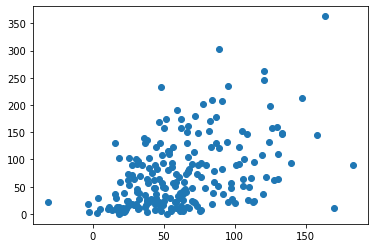

In [22]:
# Importing necessary libraries
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

 
# getting the predictions of the Validation Set...
predictions = model.predict(text_bow_test)
# it returns a list with the regression [0] and the classification [1]
plt.scatter(predictions[0],y_test_comments)

# rmse
rmse = np.sqrt(np.mean((predictions[0]-y_test_comments)**2))
display(f"RMSE: {rmse}")


matrix = confusion_matrix(y_test_author.argmax(axis=1), predictions[1].argmax(axis=1))

In [23]:
print(classification_report(y_test_author.argmax(axis=1), predictions[1].argmax(axis=1)))
display(matrix)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.00      0.00      0.00        19
          5       0.17      0.16      0.16        25
          7       0.14      0.23      0.17        30
         15       0.00      0.00      0.00        17
         16       0.10      0.67      0.18        21
         19       0.00      0.00      0.00        42
         28       0.00      0.00      0.00        10
         42       0.00      0.00      0.00        24
         48       0.00      0.00      0.00         0
         49       0.00      0.00      0.00        16
         57       0.00      0.00      0.00        12

avg / total       0.05      0.12      0.06       216



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  6,  0, 13,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  4,  4,  0, 16,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  5,  7,  0, 18,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3,  0, 14,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  7,  0, 14,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 10, 12,  0, 20,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  1,  0,  8,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  4,  0, 20,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  6,  0, 10,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  4,  1,  0,  5,  0,  0,  0,  1,  0,  0]], dtype=int64)

The Model is really bad in classifying the authors. However, this is done solely based on the prediction of the number of comments. Let's see how the model performs when the first input layer is as well available for the second prediction of the author.


## Model 2 - 

In [84]:
# Build the model with Keras
from keras.layers import Input, Dense, Concatenate, concatenate, BatchNormalization
from keras.models import Model


# Create an input layer with 2500 inputs
input_tensor = Input((2500,))

# Create the first output
output_tensor_1 = Dense(1, activation="linear", use_bias=False)(input_tensor)

# concatenate ouput 1 and the input tensor
output_tensor_1_n = BatchNormalization()(output_tensor_1)

combined_tensor = concatenate([input_tensor, output_tensor_1_n])

# Create the second output (use the first output and the input tensor as input)
output_tensor_2_1 = Dense(500, activation="sigmoid", use_bias=False)(combined_tensor)

# Create the second output (use the first output and the input tensor as input)
output_tensor_2 = Dense(58, activation="sigmoid", use_bias=False)(combined_tensor)

# Create a model with 2 outputs
model = Model(input_tensor, [output_tensor_1,output_tensor_2])

In [85]:
# Import the Adam optimizer
from keras.optimizers import Adam

# Compile the model with 2 losses and the Adam optimzer with a higher learning rate
model.compile(loss=['mean_absolute_error', 'categorical_crossentropy'], optimizer= Adam(lr=0.01),) #categorical crossentropy for multiclass

# Fit the model to the tournament training data, with 2 inputs and 2 outputs
model.fit(text_bow_train,
          [y_train_comments,y_train_author],
          epochs=10,
          verbose=True,
          batch_size=500)

Epoch 1/10
864/864 [==============================] - 0s 538us/step - loss: 79.1667 - dense_31_loss: 75.3676 - dense_33_loss: 3.5024
Epoch 2/10
864/864 [==============================] - 0s 62us/step - loss: 73.0076 - dense_31_loss: 70.0981 - dense_33_loss: 2.3324
Epoch 3/10
864/864 [==============================] - 0s 65us/step - loss: 68.6265 - dense_31_loss: 66.9468 - dense_33_loss: 2.2106
Epoch 4/10
864/864 [==============================] - 0s 73us/step - loss: 64.9513 - dense_31_loss: 62.0688 - dense_33_loss: 2.1264
Epoch 5/10
864/864 [==============================] - 0s 65us/step - loss: 61.8900 - dense_31_loss: 59.4803 - dense_33_loss: 2.0638
Epoch 6/10
864/864 [==============================] - 0s 69us/step - loss: 59.3016 - dense_31_loss: 57.5561 - dense_33_loss: 2.0113
Epoch 7/10
864/864 [==============================] - 0s 66us/step - loss: 57.3348 - dense_31_loss: 55.8750 - dense_33_loss: 1.9715
Epoch 8/10
864/864 [==============================] - 0s 63us/step - loss: 

'RMSE: 71.45537904761875'

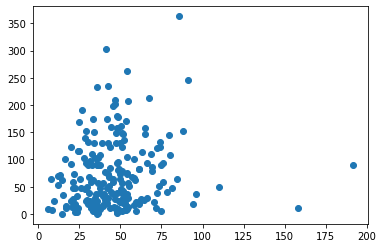

In [86]:
# Importing necessary libraries
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

 
# getting the predictions of the Validation Set...
predictions = model.predict(text_bow_test)
# it returns a list with the regression [0] and the classification [1]
plt.scatter(predictions[0],y_test_comments)

# rmse
rmse = np.sqrt(np.mean((predictions[0]-y_test_comments)**2))
display(f"RMSE: {rmse}")


matrix = confusion_matrix(y_test_author.argmax(axis=1), predictions[1].argmax(axis=1))

In [87]:
print(classification_report(y_test_author.argmax(axis=1), predictions[1].argmax(axis=1)))
display(matrix)

             precision    recall  f1-score   support

          1       0.00      0.00      0.00        19
          5       0.00      0.00      0.00        25
          7       0.23      0.77      0.36        30
         15       0.00      0.00      0.00        17
         16       0.20      0.52      0.29        21
         19       0.25      0.36      0.29        42
         28       0.00      0.00      0.00        10
         42       0.00      0.00      0.00        24
         49       1.00      0.06      0.12        16
         57       0.00      0.00      0.00        12

avg / total       0.17      0.23      0.14       216



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[ 0,  0,  4,  0, 11,  4,  0,  0,  0,  0],
       [ 0,  0,  9,  0,  6, 10,  0,  0,  0,  0],
       [ 0,  0, 23,  0,  3,  4,  0,  0,  0,  0],
       [ 0,  0,  8,  0,  8,  1,  0,  0,  0,  0],
       [ 0,  0,  4,  0, 11,  6,  0,  0,  0,  0],
       [ 0,  0, 21,  0,  6, 15,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  4,  5,  0,  0,  0,  0],
       [ 0,  0, 15,  0,  1,  8,  0,  0,  0,  0],
       [ 0,  0,  6,  0,  4,  5,  0,  0,  1,  0],
       [ 0,  0,  7,  0,  2,  3,  0,  0,  0,  0]], dtype=int64)

The accuracy increased dramatically with an additional layer